# Homework 3: MCMC
### Jake Pitkin
**CS 6190: Probabilistic Modeling - Spring 2018**<br>
**April 7 2018**

$1.$ Write a function to perform Gibbs sampling of a binary label image $x$ with the Ising model prior and iid Gaussian likelihood, given a noisy image $y$. This function should take $\alpha$, $\beta$, and $\sigma$ parameters, and generate a random binary image (labels in the set $\{-1,1\}$ according to the posterior Gibbs distribution for $x|y.$ The energy should look like this:

$$U(x) = -\alpha \sum_{i} x_i - \beta \sum_{\langle i,j\rangle} x_ix_j + \frac{1}{2\sigma^2} \sum_{i} (x_i - y_i)^2$$

Note this is assuming that the $x_i$ labels are also the mean pixel values in the Gaussian. The $\alpha$ parameter controls the proportion of labels that are $-1$ versus $+1$. Negative values of $\alpha$ will favor more $-1$ pixels, and positive values of $\alpha$ will favor more $+1$ pixels.



In [361]:
import math
import random
from PIL import Image

def open_image_transform(path):
    """ Reads an image from path.
        Applies an intensity transformation to the pixels: x * 20 - 10.
        Returns: pixel matrix, width, and height. """
    img = Image.open(path, 'r')
    pixels = img.load()
    width = img.size[0]
    height = img.size[1]
    Y = [[(pixels[x,y]/255) * 20 - 10 for x in range(width)] for y in range(height)]
    return Y, width, height

def pixels_to_image_mapped(X, width, height):
    """ Converts a pixel matrix to a binary image with a map and returns the image. """
    cmap = { -1 : (0, 0, 0), 1 : (255, 255, 255)}
    data = []
    for row in range(height):
        for col in range(width):
            data.append(cmap[X[row][col]])
    img = Image.new('RGB', (width, height), "white")
    img.putdata(data)
    return img 

# Returns the value of the four neighbours of a pixel.
# Uses wrapping to deal with pixels on the boundary of the image.
def get_neighbours(X, row, col, width, height):
    """ Returns the value of the four neighbours of a pixel.
        Uses wrapping to deal with pixels on the boundary of the image. """
    # left, right, up, and down initialized to wrap values
    neighbours = [X[row][width-1], X[row][0], X[height-1][col], X[0][col]]
    # check if we don't have to wrap and replace
    if col != 0: # left
        neighbours[0] = X[row][col-1]
    if col != width-1: #right
        neighbours[1] = X[row][col+1]
    if row != 0: #up
        neighbours[2] = X[row-1][col]
    if row != height-1:
        neighbours[3] = X[row+1][col]
    return neighbours

def random_init_matrix(width, height):
    """ Returns a randomly initialized {-1, 1} 2D matrix. """
    return [[random.choice([-1, 1]) for x in range(width)] for y in range(height)]  

**(a)** Run your code with just the Ising prior term (no posterior). Do this a few times and generate several random binary images. Try different $\alpha$ and $\beta$ terms to see what the effects are.

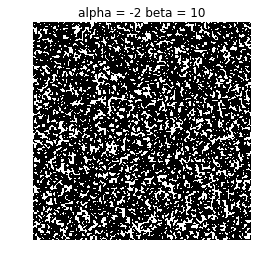

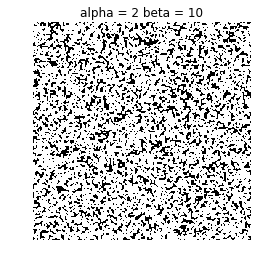

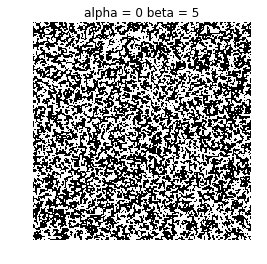

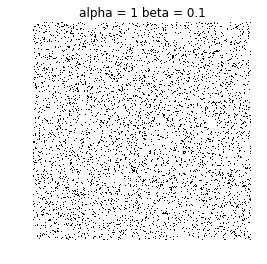

In [326]:
# Don't forget to load in helper methods in the first code block
import random
from PIL import Image
import matplotlib.pyplot as plt

def ising_prior(alpha, beta, x, X, row, col, width, height):
    prob = -1 * alpha * x
    for n in get_neighbours(X, row, col, width, height):
        prob += -1 * beta * x * n
    return prob

def ising_normalized(alpha, beta, X, row, col, width, height):
    prob = math.exp(-1 * ising_prior(alpha, beta, X[row][col], X, row, col, width, height))
    normalize = math.exp(-1 * ising_prior(alpha, beta, 1, X, row, col, width, height))
    normalize += math.exp(-1 * ising_prior(alpha, beta, -1, X, row, col, width, height))
    return prob / normalize
    
def generate_random_image(alpha, beta, X, width, height):
    for row in range(height):
        for col in range(width):
            if (row + col) % 2 == 0:
                continue
            if random.uniform(0, 1) > ising_normalized(alpha, beta, X, row, col, width, height):
                X[row][col] = X[row][col] * -1
    for row in range(height):
        for col in range(width):
            if (row + col) % 2 == 1:
                continue
            if random.uniform(0, 1) > ising_normalized(alpha, beta, X, row, col, width, height):
                X[row][col] = X[row][col] * -1
    return pixels_to_image_mapped(X, width, height)
    
width = 300
height = 300

# Random image with alpha = -2 and beta = 10
# Expect more black pixels than white pixels
X = random_init_matrix(width, height)
random1 = generate_random_image(-2, 10, X, width, height)

# Random image with alpha = 2 and beta = 10
# Expect more white pixels than black pixels
X = random_init_matrix(width, height)
random2 = generate_random_image(2, 10, X, width, height)

# Random image with alpha = 0 and beta = 5
# Expect a balance of pixels with some clustering groups
X = random_init_matrix(width, height)
random3 = generate_random_image(0, 5, X, width, height)

# Random image with alpha = 1 and beta = 0.1
# Expect little neighbour influence and mostly white pixels
X = random_init_matrix(width, height)
random4 = generate_random_image(1, 0.1, X, width, height)

# Display random images
%matplotlib inline
plt.figure()
plt.axis('off')
plt.title("alpha = -2 beta = 10")
plt.imshow(random1)
plt.figure()
plt.axis('off')
plt.title("alpha = 2 beta = 10")
plt.imshow(random2) 
plt.figure()
plt.axis('off')
plt.title("alpha = 0 beta = 5")
plt.imshow(random3) 
plt.figure()
plt.axis('off')
plt.title("alpha = 1 beta = 0.1")
plt.imshow(random4)
plt.show()

**(b)** Run your code on the images ${\tt noisy}$-${\tt message.png}$ and ${\tt noisy}$-${\tt yinyang.png}$. After you read an image, you need to apply the following intensity transform to the pixels (to get black $= -1$ and white $= +1$): 

$x \ * \ 20 \ - \ 10$

Compute the posterior mean images for both examples (again, don't forget to burn-in). You can fix values for $\alpha$, $\beta$, and $\sigma^2$ (you will want to tune these manually to get something that works well). What values of $\alpha, \beta, \sigma^2$ did you use?

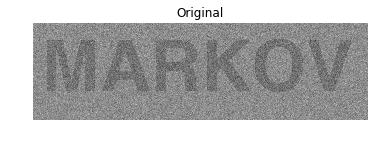

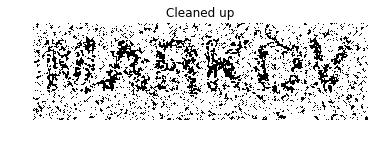

In [364]:
# Don't forget to load in helper methods in the first code block
from PIL import Image

def energy(alpha, beta, sigma, x, X, Y, row, col, width, height):
    energy = -1 * alpha * x
    for n in get_neighbours(X, row, col, width, height):
        energy += -1 * beta * x * n
    energy += (1/(2*math.pow(sigma, 2))) * math.pow(x-Y[row][col], 2)
    return energy

def cond_dist(alpha, beta, sigma, X, Y, row, col, width, height):
    prob = math.exp(-1 * energy(alpha, beta, sigma, X[row][col], X, Y, row, col, width, height))
    normalize = math.exp(-1 * energy(alpha, beta, sigma, 1, X, Y, row, col, width, height))
    normalize += math.exp(-1 * energy(alpha, beta, sigma, -1, X, Y, row, col, width, height))
    return prob / normalize

def generate_mean_image(alpha, beta, sigma, k, X, Y, width, height):
    for _ in range(k):
        for row in range(height):
            for col in range(width):
                if (row + col) % 2 == 0:
                    continue
                if random.uniform(0, 1) > cond_dist(alpha, beta, sigma, X, Y, row, col, width, height):
                    X[row][col] = X[row][col] * -1
        for row in range(height):
            for col in range(width):
                if (row + col) % 2 == 1:
                    continue
                if random.uniform(0, 1) > cond_dist(alpha, sigma, beta, X, Y, row, col, width, height):
                    X[row][col] = X[row][col] * -1
    return pixels_to_image_mapped(X, width, height)

# Read in the images
message_pixels, message_width, message_height = open_image_transform("noisy-message.png")
message_original = Image.open("noisy-message.png", 'r').convert('RGB')
yin_yang_pixels, yin_yang_width, yin_yang_height = open_image_transform("noisy-yinyang.png")
yin_yang_original = Image.open("noisy-yinyang.png").convert('RGB')

# Generate mean message image
X = random_init_matrix(message_width, message_height)
alpha = 1
beta = 1
sigma = 1
k = 1
message_mean = generate_mean_image(alpha, beta, sigma, k, 
                                   X, message_pixels, message_width, message_height)

# Generate mean yinyang image
#X = random_init_matrix(yin_yang_width, yin_yang_height)
alpha = 1
beta = 1
sigma = 1
k = 1
#yin_yang_mean = generate_mean_image(alpha, beta, sigma, k, 
    #X, yin_yang_pixels, yin_yang_width, yin_yang_height)

# Display mean images
# Display random images
%matplotlib inline
plt.figure()
plt.axis('off')
plt.title("Original")
plt.imshow(message_original)
plt.figure()
plt.axis('off')
plt.title("Cleaned up")
plt.imshow(message_mean)
#plt.figure()
#plt.axis('off')
#plt.title("Cleaned up yin-yang")
#plt.imshow(yin_yang_mean)
#plt.show()

**(c)** Use your posterior samples to iteratively estimate $\sigma^2$ from the data. That is, assume the "clean" image that you sample is the true image, and use it to get an MLE of $\sigma^2$ (update this estimate each iteration). What final estimate do you get for $\sigma^2$?

In [2]:
# 1c

$2.$ Say you are given data $(X,Y)$, with $X \in \mathbb{R}^d$ and $Y \in \{0,1\}$. The goal is to train a classifier that will predict an unknown class label $\tilde{y}$ from a new data point $\tilde{x}$. Consider the following model:

$$Y \sim Ber\Big(\frac{1}{1+e^{-X^T\beta}}\Big),$$
$$\beta \sim N(0, \sigma^2I).$$

This is a Bayesian logistic regression model. Your goal is to derive and implement a Hamiltonian Monte Carlo sampler for doing Bayesian inference on $\beta$.

**(a)** Write down the formula for the unormalized posterior of $\beta|Y$, i.e.,

$$p(\beta|y;x,\sigma) \propto \prod_{i=1}^n p(y_i|\beta;x_i)p(\beta;\sigma)$$

**(b)** Show that this posterior is proportional to exp($-U(\beta))$), where

$$U(\beta) = \sum_{i=1}^n (1 - y_i)x_i^T \beta + log(1 + e^{-x_i^T \beta}) + \frac{1}{2\sigma^2}||\beta||^2$$

**(c)** Implement a Hamiltonian Monte Carlo Routine in Python for sampling from the posterior of $\beta$.

In [3]:
# 2c

**(d)** Use your code to analyze the ${\tt iris}$ data in Python, looking only at two species, *versicolor* and *virginica*. The species labels are your $Y$ data, and the four features, petal length and width, sepal length and width, are your $X$ data. Also, add a constant term, i.e., a columns of 1's to your $X$ matrix. Use the first 30 rows for each species as training data and leave out the last $20$ rows for each species as test data (for a total of $60$ training and $40$ testing). Generate samples of $\beta$ (don't forget to burn-in), and use these to get a prediction, $\tilde{y}$, of the class labels for the test data. Use your samples to get a Monte Carlo estimate of the posterior predictive probability $p(\tilde{y}|y)$ for each testing data point.

In [ ]:
# 2d

**(e)** Draw trace plots of your $\beta$ sequence and histograms (do 1D plots of each four vector components separately).

In [4]:
# 2e

**(f)** Compare this to the true class labels, $y$, and see how well you did by estimating the average error rate, $E[|y - \tilde{y}|]$ (a.k.a. the zero-one loss). What values of $\sigma$, $\epsilon$, and $L$ did you use?

In [ ]:
# 2f